'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


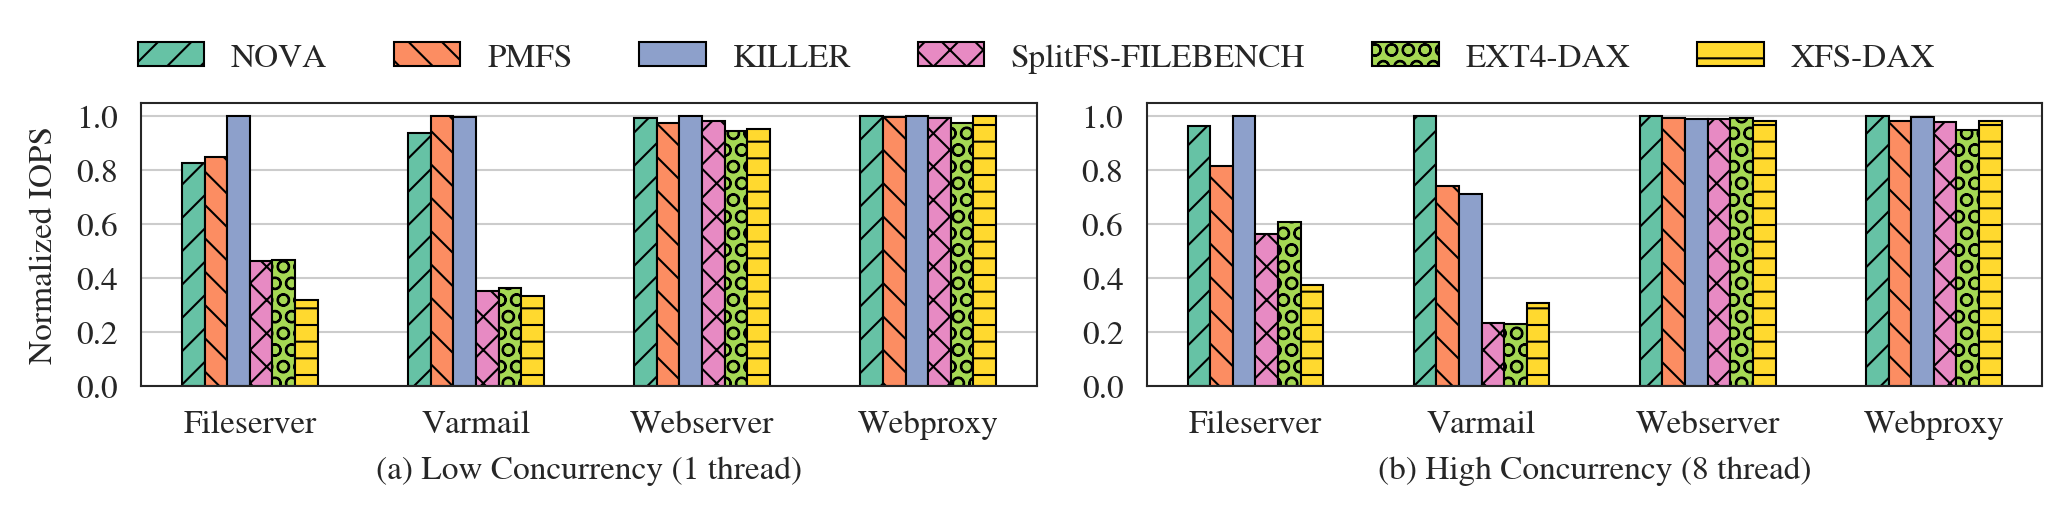

In [4]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec


# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(4)))
bar_width = 0.1
subfig_titles = ["(a) Low Concurrency (1 thread)", "(b) High Concurrency (8 thread)"]
patterns = ['///', '\\\\\\', '', 'XXX', 'OOO', '---', '+++']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = ["#2b2d42", "#8d99ae", "#edf2f4", "#ef233c", "#ef233c", "#ef233c", "#ef233c", "#ef233c",]

fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
workloads = ["fileserver.f", "varmail.f", "webserver.f", "webproxy.f"]
# workloads_name_remap = ["Fileserver", "Varmail", "Webserver", "Webproxy", "Fileserver-8", "Varmail-8", "Webserver-8", "Webproxy-8"]
workloads_name_remap = ["Fileserver", "Varmail", "Webserver", "Webproxy"]
tot = len(fss) * bar_width
x = list(range(1, len(workloads) + 1))
num_threads = [1, 8]
for thread in num_threads:
    for workload in workloads:
        value = df[(df['file_bench'] == workload) & (df['threads'] == thread)]['iops'] / df[(df['file_bench'] == workload) & (df['threads'] == thread)]['iops'].max()
        df.loc[(df['file_bench'] == workload) & (df['threads'] == thread), 'iops'] = value

for fig_idx in range(0, len(num_threads)):
    subfig = plt.subplot(1, 2, fig_idx + 1)
    for idx, fs in enumerate(fss):
        points = []
        for pivot in x:
            point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
            points.append(point)
        bws = []
        for workload in workloads:
            bws.append(df[(df['file_system'] == fs) & (df['file_bench'] == workload) & (df['threads'] == num_threads[fig_idx])]['iops'].iloc[0])
        
        plt.bar(points, bws, width=bar_width, hatch=patterns[idx], edgecolor='black', color=plt.get_cmap('Set2')(idx), linewidth=0.5)

        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        
        # Draw title
        plt.xticks(x, labels=workloads_name_remap, fontsize=8)
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
        if fig_idx == 0:
            plt.ylabel('Normalized IOPS', fontsize=8)
        plt.xlabel(subfig_titles[fig_idx], fontsize=8)
    
legend_labels = fss
fig.legend(legend_labels, loc='center', bbox_to_anchor=(0.5, 1), ncol=6, fontsize=8, frameon=False)
plt.tight_layout()
plt.savefig("./FIG-Filebench.pdf", bbox_inches='tight', pad_inches=0)
